In [140]:
num_workers = 2
num_clients = 2

client_task_orders = [
  [0,1],
  [0,1]
]

a_disk_cost = 0.1 * 1
a_cpu_cost = 0.1 * 1
b_disk_cost = 0.1 * 1
b_cpu_cost = 0.1 * 1

core_resources = 1
disk_resources = 3.05

client_divisors = [2, 2]

interval_seconds = 1

client_starts = []
client_durations = []
task_types = []  # 0 - disk read, 1 - compute
for _ in range(num_clients):
  client_starts.append([])
  client_durations.append([])
  task_types.append([])

for i in range(num_workers):
  with open('results/results_' + str(i) + '.txt', 'r') as file:
    # Iterate over each line in the file
    execution_order = [int(x) for x in file.readline().strip().split(':')[1].split(',')[:-1]]
    for j in range(num_clients):
      durs = [int(x) for x in file.readline().strip().split(':')[1].split(',')[:-1]]
      client_durations[j].extend(durs)
      task_types[j].extend([i for x in range(len(durs))])
    for j in range(num_clients):
      client_starts[j].extend([int(x) for x in file.readline().strip().split(':')[1].split(',')[:-1]])

# Get rid of 0s that might happen due to imbalance
for i in range(len(client_starts)):
  new_starts = []
  new_durations = []
  new_task_types = []
  for j in range(len(client_starts[i])):
    if client_starts[i][j] != 0:
      new_starts.append(client_starts[i][j])
      new_durations.append(client_durations[i][j])
      new_task_types.append(task_types[i][j])
  client_starts[i] = new_starts
  client_durations[i] = new_durations
  task_type = new_task_types
  

# for i in range(len(client_starts)):
#   print(client_starts[i])
#   print(client_durations[i])
#   for j in range(len(client_starts[i])):
#     if client_starts[i][-1 - j] == 0:
#       continue
#     client_starts[i] = client_starts[i][0:len(client_starts[i])-j]
#     break
#   print(client_starts[i])
  

absolute_start = min(client_starts[0] + client_starts[1])
for i in range(len(client_starts)):
  client_durations[i] = [y for _, y in sorted(zip(client_starts[i], client_durations[i]))]
  task_types[i] = [y for _, y in sorted(zip(client_starts[i], task_types[i]))]
  client_starts[i] = sorted(client_starts[i])
  client_starts[i] = [start - absolute_start for start in client_starts[i]]
  print(f'Client {i} starts: {client_starts[i]}')
  print(f'Client {i} durs: {client_durations[i]}')
  print(f'Client {i} task_types: {task_types[i]}')

Client 0 starts: [0, 40446, 77421, 112615, 145837, 179062, 213515, 241794, 246400, 280084, 314125, 342383, 348421, 382157, 415278, 443219, 449026, 483992, 518558, 544590, 555575, 596636, 641328, 646026, 679495, 724981, 747640, 766231, 799946, 832898, 848308, 868742, 905969, 939869, 949002, 974633, 1008949, 1046133, 1049752, 1079657, 1113785, 1150397, 1150439, 1183553, 1217545, 1251052, 1255413, 1289935, 1323507, 1351754, 1356439, 1394287, 1427629, 1452418, 1465087, 1499554, 1537739, 1552805, 1572156, 1606288, 1640798, 1653522, 1675471, 1709483, 1747174, 1754226, 1780990, 1816213, 1851496, 1854977, 1888845, 1925796, 1955839, 1960336, 1997641, 2031112, 2056557, 2064394, 2098184, 2133718, 2157248, 2169748, 2203710, 2237567, 2257876, 2271221, 2358287, 2409236, 2445395, 2458942, 2479509, 2513415, 2549126, 2559602, 2585704, 2622171, 2660242, 2693056, 2727443, 2761073, 2761960, 2796815, 2833589, 2861716, 2867175, 2901348, 2935998, 2962364, 3005486, 3041230, 3063294, 3075557, 3109848, 3145551,

In [141]:
# Split up disk and compute ops for each client
per_resource_starts = [[[], []],[[], []]]
per_resource_durs = [[[], []],[[], []]]

for i in range(len(client_starts)):
  for j in range(len(client_starts[i])):
    start = client_starts[i][j]
    dur = client_durations[i][j]
    resource = task_types[i][j]
    per_resource_starts[i][resource].append(start)
    per_resource_durs[i][resource].append(dur)

for i in range(len(per_resource_starts)):
  for j in range(len(per_resource_starts[i])):
    print(per_resource_starts[i][j])
    print(per_resource_durs[i][j])
    print()

[0, 77421, 112615, 145837, 179062, 213515, 246400, 280084, 314125, 348421, 382157, 415278, 449026, 483992, 518558, 555575, 596636, 641328, 679495, 724981, 766231, 799946, 832898, 868742, 905969, 939869, 974633, 1008949, 1046133, 1079657, 1113785, 1150439, 1183553, 1217545, 1255413, 1289935, 1323507, 1356439, 1394287, 1427629, 1465087, 1499554, 1537739, 1572156, 1606288, 1640798, 1675471, 1709483, 1747174, 1780990, 1816213, 1851496, 1888845, 1925796, 1960336, 1997641, 2031112, 2064394, 2098184, 2133718, 2169748, 2203710, 2237567, 2271221, 2409236, 2445395, 2479509, 2513415, 2549126, 2585704, 2622171, 2693056, 2727443, 2761960, 2796815, 2833589, 2867175, 2901348, 2935998, 3005486, 3041230, 3075557, 3109848, 3145551, 3179978, 3218585, 3252765, 3320221, 3357688, 3391469, 3426186, 3459977, 3494611, 3528469, 3563680, 3633713, 3667843, 3701220, 3736942, 3782260, 3879178, 3983269, 4077800, 4178429, 4283418, 4387488, 4483466, 4589083, 4682372, 4786349, 4890515, 4988848, 5093197, 5187181, 529103

In [142]:
def fine_grain_chunk(starts, durs):
  time_interval = int(interval_seconds * 1000000)
  num_chunks = (starts[-1] + durs[-1]) // time_interval + 2
  print(f'Num chunks: {num_chunks}')
  chunked_resource_usage = [0] * num_chunks

  for i in range(len(starts)):
    start = starts[i]
    dur = durs[i]
    while dur > 0:
      chunk_idx = start // time_interval
      if chunk_idx >= len(chunked_resource_usage):
        break
      chunk_val = min(dur, (chunk_idx + 1) * time_interval - start)
      chunked_resource_usage[chunk_idx] += chunk_val
      # chunk_idx += 1
      start += chunk_val
      dur -= chunk_val
  return chunked_resource_usage

print('Chunked:')
client1_cpu_chunked_starts = fine_grain_chunk(per_resource_starts[0][1], per_resource_durs[0][1])
client2_cpu_chunked_starts = fine_grain_chunk(per_resource_starts[1][1], per_resource_durs[1][1])
print(client1_cpu_chunked_starts)
print(client2_cpu_chunked_starts)

client1_disk_chunked_starts = fine_grain_chunk(per_resource_starts[0][0], per_resource_durs[0][0])
client2_disk_chunked_starts = fine_grain_chunk(per_resource_starts[1][0], per_resource_durs[1][0])
print(client1_disk_chunked_starts)
print(client2_disk_chunked_starts)

print('Cumulative Usage:')
# Total CPU usage over time for each client
total_cpu = 0
client1_cumulative_cpu = []
for usage in client1_cpu_chunked_starts:
  total_cpu += usage / 1000000
  client1_cumulative_cpu.append(total_cpu)
print(client1_cumulative_cpu)
total_cpu = 0
client2_cumulative_cpu = []
for usage in client2_cpu_chunked_starts:
  total_cpu += usage / 1000000
  client2_cumulative_cpu.append(total_cpu)
print(client2_cumulative_cpu)

total_disk = 0
client1_cumulative_disk = []
client1_cumulative_disk_x = []
for i in range(len(per_resource_starts[0][1])):
  start = per_resource_starts[0][1][i]
  client1_cumulative_disk_x.append(start / 1000000)
  total_disk += 0.1
  client1_cumulative_disk.append(total_disk)

total_disk = 0
client2_cumulative_disk = []
client2_cumulative_disk_x = []
for i in range(len(per_resource_starts[1][1])):
  start = per_resource_starts[1][1][i]
  client2_cumulative_disk_x.append(start / 1000000)
  total_disk += 0.1
  client2_cumulative_disk.append(total_disk)

print('Utilization Timeseries:')
client1_cpu_util = [100 * usage / interval_seconds / 1000000 for usage in client1_cpu_chunked_starts]
client2_cpu_util = [100 * usage / interval_seconds / 1000000 for usage in client2_cpu_chunked_starts]
print(client1_cpu_util)
print(client2_cpu_util)

Chunked:
Num chunks: 62
Num chunks: 61
[859028, 999930, 999931, 999920, 999938, 999944, 697928, 899012, 898562, 899224, 899222, 899027, 899207, 843969, 853311, 899208, 868799, 828945, 899176, 899167, 899190, 798228, 899213, 899147, 898816, 798379, 899279, 899254, 899279, 798515, 899246, 899332, 891741, 805944, 899357, 899163, 899240, 797344, 898916, 898928, 899302, 798401, 898954, 899270, 899136, 798145, 899308, 899295, 899168, 798436, 899252, 899252, 899059, 798337, 899259, 899283, 899191, 798603, 898339, 898545, 95881, 0]
[100461, 0, 0, 0, 0, 0, 301998, 100921, 101375, 100701, 100716, 100917, 100725, 155942, 146616, 100724, 131146, 171009, 100773, 100782, 100766, 201711, 100723, 100778, 101130, 201542, 100665, 100692, 100678, 201419, 100700, 100608, 108211, 194006, 100587, 100781, 100708, 202592, 101029, 101003, 100648, 201543, 100994, 100671, 100801, 201790, 100633, 100659, 100765, 201502, 100690, 100654, 100873, 201601, 100684, 100650, 100753, 201343, 101614, 101391, 0]
Num chunks:

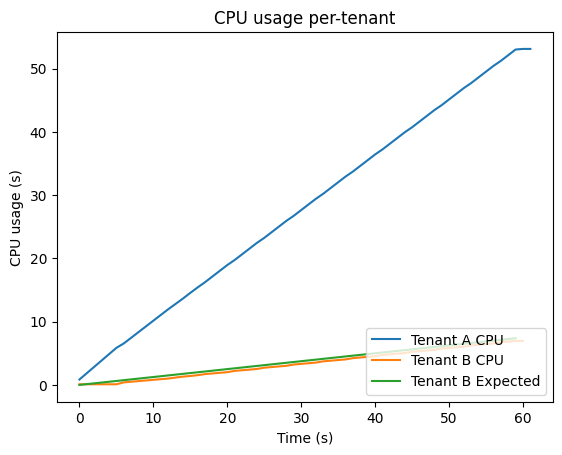

In [145]:
import matplotlib.pyplot as plt

_, ax = plt.subplots()
ax.set_title('CPU usage per-tenant')
ax.set_ylabel('CPU usage (s)')
ax.set_xlabel('Time (s)')

# client1_cpu_util = client1_cpu_util[:int(30 // interval_seconds)]
# client2_cpu_util = client2_cpu_util[:int(30 // interval_seconds)]



ax.plot([x * interval_seconds for x in list(range(len(client1_cumulative_cpu)))], client1_cumulative_cpu, label='Tenant A CPU')
ax.plot([x * interval_seconds for x in list(range(len(client2_cumulative_cpu)))], client2_cumulative_cpu, label='Tenant B CPU')
ax.plot(list(range(30)), [(x / .2) * .1 for x in range(60)], label='Tenant B Expected')
# ax.plot(list(range(30)), [(x / .01) * .1 for x in range(60)], label='Tenant A Expected')
ax.legend(loc='lower right')

plt.show()

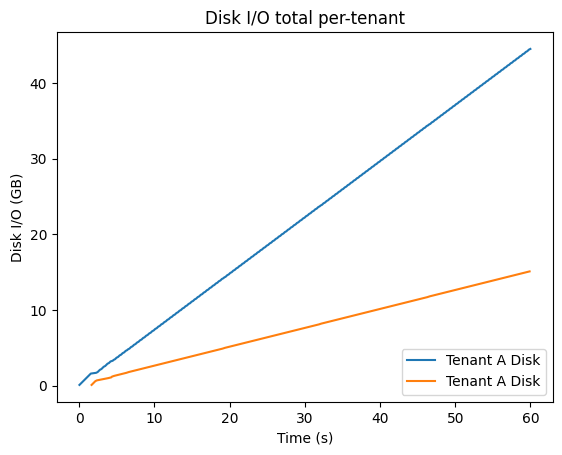

In [129]:
import matplotlib.pyplot as plt

_, ax = plt.subplots()
ax.set_title('Disk I/O total per-tenant')
ax.set_ylabel('Disk I/O (GB)')
ax.set_xlabel('Time (s)')

# client1_cumulative_disk = client1_cumulative_disk[:int(30 // interval_seconds)]
# client2_cumulative_disk = client2_cumulative_disk[:int(30 // interval_seconds)]
ax.plot(client1_cumulative_disk_x, client1_cumulative_disk, label='Tenant A Disk')
ax.plot(client2_cumulative_disk_x, client2_cumulative_disk, label='Tenant A Disk')
ax.legend(loc='lower right')

plt.show()


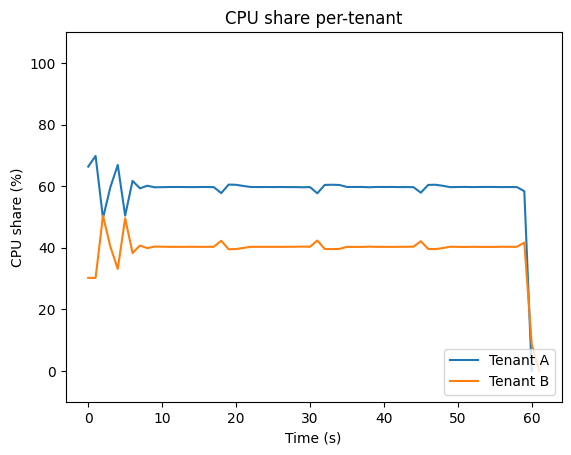

In [109]:
import matplotlib.pyplot as plt

_, ax = plt.subplots()
ax.set_title('CPU share per-tenant')
ax.set_ylabel('CPU share (%)')
ax.set_xlabel('Time (s)')
ax.set_ylim(-10,110)


# client1_cpu_util = client1_cpu_util[:int(30 // interval_seconds)]
# client2_cpu_util = client2_cpu_util[:int(30 // interval_seconds)]
ax.plot([x * interval_seconds for x in list(range(len(client1_cpu_util)))], client1_cpu_util, label='Tenant A')
ax.plot([x * interval_seconds for x in list(range(len(client2_cpu_util)))], client2_cpu_util, label='Tenant B')
ax.legend(loc='lower right')

plt.show()

In [113]:
# Per-client QPS
for i in range(len(client_starts)):
  starts = client_starts[i]
  run_start = starts[0]
  run_end = starts[-1] + client_durations[i][-1]
  qpus = len(starts) / (run_end - run_start)
  qps = qpus * 1000000
  print(f'Client {i} QPS = {qps/client_divisors[i]}')
print(f'Num full ops: {len(client_starts[0]) / client_divisors[0]}, {len(client_starts[1])/client_divisors[1]}')
  
# Total system utilization
# CPU: total compute time used / total time of experiment * 2 CPUs
a_cpu_usage = a_cpu_cost * len(client_starts[0]) / client_divisors[0]
b_cpu_usage = b_cpu_cost * len(client_starts[1]) / client_divisors[1]
cpu_usage = a_cpu_usage + b_cpu_usage
print(f'CPU usage: {a_cpu_usage}, {b_cpu_usage}')

a_disk_usage = a_disk_cost * len(client_starts[0]) / client_divisors[0]
b_disk_usage = b_disk_cost * len(client_starts[1]) / client_divisors[1]
disk_usage = a_disk_usage + b_disk_usage
print(f'Disk usage: {a_disk_usage}, {b_disk_usage}')

run_duration_us = max(client_starts[0][-1] + client_durations[0][-1], client_starts[1][-1] + client_durations[1][-1])
run_duration_s = run_duration_us / 1000000
print(f'Total run duration: {run_duration_s}s')

cpu_util = cpu_usage / (run_duration_s * core_resources)
print(f'CPU util: {cpu_util}')

# cpu_util2 = cpu_usage / (run_duration_s * core_resources - disk_usage/disk_resources)
# print(f'CPU util w/o disk: {cpu_util2}')

disk_util = disk_usage / (run_duration_s * disk_resources)
print(f'Disk util: {disk_util}')


Client 0 QPS = 6.059687067424196
Client 1 QPS = 4.079735210864111
Num full ops: 363.5, 245.0
CPU usage: 36.35, 24.5
Disk usage: 36.35, 24.5
Total run duration: 60.087272s
CPU util: 1.0126936699672437
Disk util: 0.33203071146467006


In [ ]:
# Pipelined workers
num_workers = 4
num_clients = 2

client_starts = []
client_durations = []
for _ in range(num_clients):
  client_starts.append([])
  client_durations.append([])

for i in range(num_workers):
  with open('results/results_' + str(i) + '.txt', 'r') as file:
    # Iterate over each line in the file
    execution_order = [int(x) for x in file.readline().strip().split(':')[1].split(',')[:-1]]
    for j in range(num_clients):
      client_durations[j].extend([int(x) for x in file.readline().strip().split(':')[1].split(',')[:-1]])
    for j in range(num_clients):
      client_starts[j].extend([int(x) for x in file.readline().strip().split(':')[1].split(',')[:-1]])

absolute_start = min(client_starts[0] + client_starts[1])
for i in range(len(client_starts)):
  client_durations[i] = [y for _, y in sorted(zip(client_starts[i], client_durations[i]))]
  client_starts[i] = sorted(client_starts[i])
  client_starts[i] = [start - absolute_start for start in client_starts[i]]

In [ ]:
# First attempt: Plot each worker's execution order
# Issue: this merges together sequential ops of same client
worker_executions = []
worker_starts = []

for i in range(num_workers):
  with open('results/results_' + str(i) + '.txt', 'r') as file:
    # Iterate over each line in the file
    worker_executions.append([int(x) for x in file.readline().strip().split(':')[1].split(',')[:-1]])
    for j in range(num_clients):
      _ = [int(x) for x in file.readline().strip().split(':')[1].split(',')[:-1]]
    worker_starts.append([])
    for j in range(num_clients):
      worker_starts[i].append([int(x) - absolute_start for x in file.readline().strip().split(':')[1].split(',')[:-1]])

worker_timelines = []
for i in range(len(worker_executions)):
  client_counts = [0, 0]
  exec_order = worker_executions[i]
  worker_timelines.append([])
  for client in exec_order:
    worker_timelines[i].append(worker_starts[i][client][client_counts[client]])
    client_counts[client] += 1

def stepify(x, y):
  # for every xn, yn: need an xn+1,yn
  new_x = [x[0]]
  new_y = []
  for i in range(1, len(x)):
    new_x.append(x[i])
    new_x.append(x[i])
  new_x.append(new_x[-1])
  for i in range(len(y)):
    new_y.append(y[i])
    new_y.append(y[i])
  return new_x, new_y

  # Worker 1's (idx 0's) execution order
# x-axis: time
# y-axis: client serving

import matplotlib.pyplot as plt

fig, axarr = plt.subplots(4, 1, sharex=True, sharey=True,figsize=(8, 8))

for i in range(len(worker_timelines)):
  x, y = stepify(worker_timelines[i], worker_executions[i])
  axarr[i].plot(x, y, label=f'Worker ' + str(i))

fig.suptitle('Client Serving Times', fontsize=16)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

_, ax = plt.subplots()
ax.set_title('Total op count in time window')
ax.set_ylabel('Op count')
ax.set_xlabel('Time (s)')
# ax.set_ylim(0,100)

ax.plot([x * interval_seconds for x in list(range(len(client1_chunked_starts)))], client1_chunked_starts, label='Tenant A')
ax.plot([x * interval_seconds for x in list(range(len(client2_chunked_starts)))], client2_chunked_starts, label='Tenant B')
ax.legend(loc='lower right')

plt.show()

In [ ]:
import matplotlib.pyplot as plt

_, ax = plt.subplots()
ax.set_title('Dominant resource share per-tenant')
ax.set_ylabel('Dominant resource share (%)')
ax.set_xlabel('Time (s)')
ax.set_ylim(0,100)

# how_many = 30
# how_many = len(client1)
# x_axis = list(range(how_many))
# x_axis = [x * 3 for x in list(range(how_many))]

ax.plot([x * interval_seconds for x in list(range(len(client1_cpu_util)))], client1_cpu_util, label='Tenant A')
ax.plot([x * interval_seconds for x in list(range(len(client2_disk_util)))], client2_disk_util, label='Tenant B')
ax.legend(loc='lower right')

plt.show()

In [ ]:
# Metrics:
# Dominant resource share over time

In [ ]:
# Per-client QPS
for i in range(len(client_starts)):
  starts = client_starts[i]
  run_start = starts[0]
  run_end = starts[-1] + client_durations[i][-1]
  qpus = len(starts) / (run_end - run_start)
  qps = qpus * 1000000
  print(f'Client {i} QPS = {qps}')

In [ ]:
a_cpu_cost = .3
b_cpu_cost = .3
a_disk_cost = 2
b_disk_cost = .5

core_resources = 2
disk_resources = 3.9

# Per-client QPS
for i in range(len(client_starts)):
  starts = client_starts[i]
  run_start = starts[0]
  run_end = starts[-1] + client_durations[i][-1]
  qpus = len(starts) / (run_end - run_start)
  qps = qpus * 1000000
  print(f'Client {i} QPS = {qps/2}')
  
# Total system utilization
# CPU: total compute time used / total time of experiment * 2 CPUs
cpu_usage = 0
cpu_usage += a_cpu_cost * len(client_starts[0]) / 2
cpu_usage += b_cpu_cost * len(client_starts[1]) / 2

disk_usage = 0
disk_usage += a_disk_cost * len(client_starts[0]) / 2
disk_usage += b_disk_cost * len(client_starts[1]) / 2
print(len(client_starts[0]))  # 250 - 250GB
print(len(client_starts[1]))  # 250 - 125GB

# Pipeline: Least service
# 167 - 167GB, 41.75cpu
# 333 - 167GB, 83.25cpu

# Pipeline: Least service - Rogue A
# 167 - 167GB, 83.5cpu
# 333 - 167GB, 83.25cpu

# Pipeline: Least service - Rogue A.2
# 167 - 167GB, 83.5cpu
# 333 - 167GB, 83.25cpu
run_duration_us = max(client_starts[0][-1] + client_durations[0][-1], client_starts[1][-1] + client_durations[1][-1])
run_duration_s = run_duration_us / 1000000
print(f'Total run duration: {run_duration_s}s')

cpu_util = cpu_usage / (run_duration_s * core_resources)
print(f'CPU util: {cpu_util}')

# cpu_util2 = cpu_usage / (run_duration_s * core_resources - disk_usage/disk_resources)
# print(f'CPU util w/o disk: {cpu_util2}')

disk_util = disk_usage / (run_duration_s * disk_resources)
print(f'Disk util: {disk_util}')


In [ ]:
# Dominant resource share over time
# 1. every Xs, how many ongoing ops are there? multiple this by resource usage and determine dominant share
# 2. sliding window of Xs, how may resources were used in this interval?

# 1
# for each client
# 
# let's say every 100ms
interval_us = 1000000  # in microseconds (100ms)
num_interval = 42  # duration of experiment
intervals_us = [interval_us * t for t in range(1,num_interval)]
client_counts = []
for i in range(len(client_starts)):
  client_counts.append([0] * len(list(range(1, num_interval))))

for i in range(len(intervals_us)):
  t = intervals_us[i]
  # find all the ops that were ongoing at this point in time
  for j in range(len(client_starts)):
    starts = client_starts[j]
    durs = client_durations[j]
    # print(len(starts), len(durs))
    for k in range(len(starts)):
      start = starts[k]
      dur = durs[k]
      if start > t:
        break
      if start + dur < t:
        continue
      if start <= t and start + dur > t:
        client_counts[j][i] += 1

# interval_available_cpu = 2 * interval_us  # 2 cores
# interval_available_disk = 3 * interval_us / 1000000  # 3 GB/s (3KB/us)

for counts in client_counts:
  print(counts)

client1_cpu_share = [100 * 2/3 * x / 2 for x in client_counts[0]]  # 2 cores

# Without disk:
# client1_cpu_share = [100 * 2/3 * x / 3.3 for x in client_counts[0]]
# print(client1_disk_share)
print(client1_cpu_share)

client2_disk_share = [100 * 1 * x / 3 for x in client_counts[1]]
# client2_cpu_share = [100 * 1/12 * x / 2 for x in client_counts[1]]
print(client2_disk_share)
# print(client2_cpu_share)

# client1_disk_util = [100 * 1/9 * num_tasks /interval_seconds for num_tasks in client1_chunked_starts]
# client1_cpu_util = [100 * 4/18 * num_tasks /interval_seconds for num_tasks in client1_chunked_starts]

# client2_disk_util = [100 * 3/9 * num_tasks /interval_seconds for num_tasks in client2_chunked_starts]
# client2_cpu_util = [100 * 1/18 * num_tasks /interval_seconds for num_tasks in client2_chunked_starts]

In [ ]:
import matplotlib.pyplot as plt

# 1. every Xs, how many ongoing ops are there? multiple this by resource usage and determine dominant share
_, ax = plt.subplots()
ax.set_title('Dominant resource share per-tenant')
ax.set_ylabel('Dominant resource share (%)')
ax.set_xlabel('Time (s)')
ax.set_ylim(0,100)

# how_many = 30
# how_many = len(client1)
# x_axis = list(range(how_many))
# x_axis = [x * 3 for x in list(range(how_many))]

ax.plot(list(range(len(client1_cpu_share))), client1_cpu_share, label='Tenant A')
ax.plot(list(range(len(client2_disk_share))), client2_disk_share, label='Tenant B')
ax.legend(loc='lower right')

plt.show()

In [ ]:
import numpy as np
test_durs = [330574, 3764471, 329101, 325010, 325482, 389163, 328179, 1713829, 341810, 329296, 344663, 329967, 330348, 328837, 331106, 719824, 330959, 324065, 319290, 327520, 332352, 332737, 333387, 326639, 325633, 323373, 334799, 328759, 330694, 331403, 332784, 324388, 321490, 327198, 326500, 329851, 326390, 324964, 331352, 323411, 322528, 331891, 331070, 330013, 325360, 428757, 332497, 325994, 403792, 331430, 1442292, 331121, 327422, 323844, 331436, 331421, 328469, 327354, 323659, 323084, 325941, 326331, 326782, 322325]
print(np.mean(test_durs))
print(np.percentile(test_durs, 50))
print(np.percentile(test_durs, 90))
print(np.percentile(test_durs, 99))
print()
print(np.mean(test_durs[16:]))
print(np.percentile(test_durs[16:], 50))
print(np.percentile(test_durs[16:], 90))
print(np.percentile(test_durs[16:], 99))

print(sorted(test_durs, reverse=True))